<a href="https://colab.research.google.com/github/viniciusacosta/rent_calculator/blob/main/machine_learning/model_imoveis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Importando Bibliotecas**

In [60]:
## Importando bibliotecas necessárias para o projeto
# Bibliotecas para a manipulação, exploração dos e visualização do conjuntos de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de aprendizado de máquina
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from yellowbrick.contrib.wrapper import wrap
from sklearn.linear_model import RidgeCV, Lasso, ElasticNet, LassoLars, HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Bibliotecas para avaliação dos modelos.
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import pickle
import time
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Carregando dados**

In [127]:
# Carregando conjunto de dados.
df = pd.read_csv('https://raw.githubusercontent.com/viniciusacosta/rent_calculator/main/data_cleaning/apto_capitais_data.csv')

# Exibindo as primeiras linhas do DataFrame
df.head()

,Unnamed: 0,crawled_at,address,estado,city,area,rooms,bathrooms,garage,condo,price_rent
0,2,2022-06-23 21:10:00,"Rua Maria Vasconcelos de Andrade, 1720 - Aruan...",SE,aracaju,80.0,3.0,2.0,1.0,400.0,750.0
1,3,2022-06-23 21:10:00,"Luzia, Aracaju - SE",SE,aracaju,67.0,2.0,1.0,1.0,395.0,1250.0
2,4,2022-06-23 21:10:00,"Avenida São João Batista, 638 - Ponto Novo, Ar...",SE,aracaju,70.0,3.0,1.0,1.0,380.0,1200.0
3,5,2022-06-23 21:10:00,"Rua Matilde Silva Lima, 421 - Luzia, Aracaju - SE",SE,aracaju,65.0,3.0,1.0,1.0,375.0,800.0
4,6,2022-06-23 21:10:00,"Luzia, Aracaju - SE",SE,aracaju,59.0,3.0,1.0,1.0,370.0,850.0


In [128]:
# Retirando colunas indesejadas
df.drop(columns=['Unnamed: 0'], inplace=True)

# Resultado da transformação
df.columns

Index(['crawled_at', 'address', 'estado', 'city', 'area', 'rooms', 'bathrooms',
       'garage', 'condo', 'price_rent'],
      dtype='object')

In [129]:
# Verificando as dimensões do dataset.
df.shape

(2659, 10)

## **Análise Exploratória dos Dados**

In [130]:
df[["area", "rooms", "bathrooms", "garage", 'condo', "price_rent"]].describe().T

,count,mean,std,min,25%,50%,75%,max
area,2659.0,92.060925,1.089451e+02,10.0,55.0,73.0,103.0,4700.0
rooms,2659.0,2.282813,9.231829e-01,1.0,2.0,2.0,3.0,7.0
bathrooms,2659.0,2.001880,1.170716e+00,1.0,1.0,2.0,3.0,8.0
garage,2659.0,1.254983,1.085357e+00,0.0,1.0,1.0,2.0,30.0
condo,2659.0,38678.903723,1.939297e+06,1.0,363.0,600.0,931.5,100000000.0
price_rent,2659.0,3909.618278,3.041381e+04,395.0,1350.0,2100.0,3400.0,1300000.0


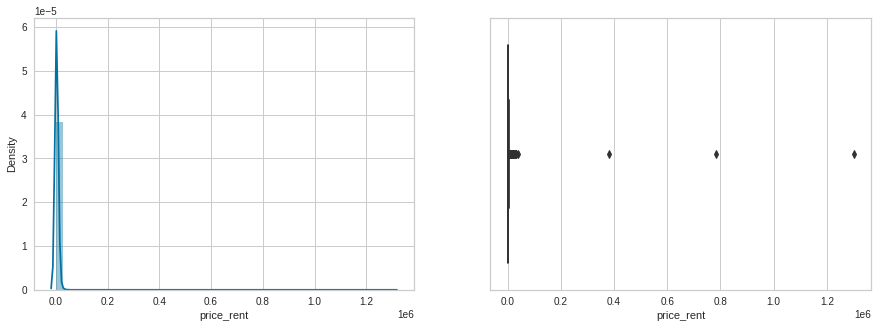

In [131]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.distplot(df['price_rent'], ax = axes[0])
sns.boxplot(df['price_rent'], ax = axes[1])
plt.show()

In [132]:
df[df.price_rent >= 5000]

,crawled_at,address,estado,city,area,rooms,bathrooms,garage,condo,price_rent
48,2022-06-23 21:11:00,"Jardins, Aracaju - SE",SE,aracaju,300.0,4.0,5.0,4.0,1300.0,10000.0
63,2022-06-23 21:16:00,"Alameda Zaire, 50 - Ponta Negra, Manaus - AM",AM,manaus,153.0,3.0,5.0,2.0,1400.0,8500.0
67,2022-06-23 21:16:00,"Ponta Negra, Manaus - AM",AM,manaus,190.0,3.0,3.0,3.0,1700.0,9500.0
71,2022-06-23 21:16:00,"Alameda Alaska, 4 - Ponta Negra, Manaus - AM",AM,manaus,270.0,4.0,5.0,4.0,3000.0,10000.0
73,2022-06-23 21:17:00,"Avenida Mário Ypiranga, 1779 - Adrianópolis, M...",AM,manaus,320.0,4.0,5.0,3.0,3000.0,9500.0
...,...,...,...,...,...,...,...,...,...,...
2635,2022-06-23 22:18:00,"Rua 15, 131 - Jardim Goiás, Goiânia - GO",GO,goiania,462.0,4.0,5.0,4.0,1500.0,9200.0
2637,2022-06-23 22:18:00,"Rua 13, 1 - Jardim Goiás, Goiânia - GO",GO,goiania,187.0,4.0,5.0,4.0,850.0,7500.0
2638,2022-06-23 22:18:00,"Avenida T 3, 1521 - Setor Bueno, Goiânia - GO",GO,goiania,180.0,4.0,5.0,3.0,800.0,6800.0
2648,2022-06-23 22:19:00,"Avenida H, 21 - Jardim Goiás, Goiânia - GO",GO,goiania,345.0,4.0,6.0,3.0,2800.0,15000.0


Podemos observar a presença de alguns outliers nos valores de aluguel (price_rent), possivelmente sendo o preço de venda do imóvel, o que indica algum erro de digitação ou na captação dos dados.

Vemos também que os outliers começam próximo aos 40000.

In [133]:
# Removendo imóveis com valores de venda
df = df.drop(df[df.price_rent >= 5000].index)

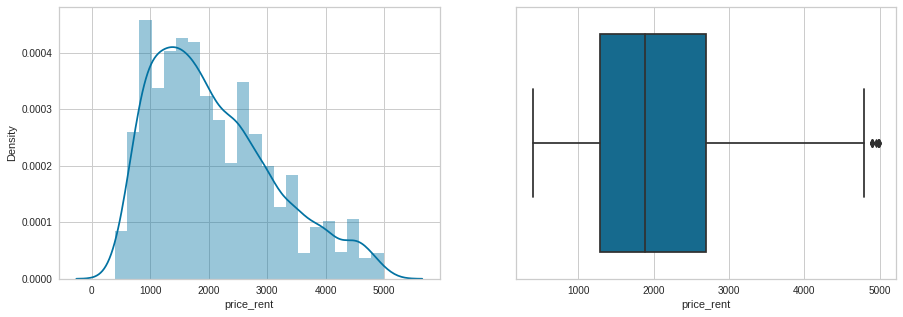

In [134]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.distplot(df['price_rent'], ax = axes[0])
sns.boxplot(df['price_rent'], ax = axes[1])
plt.show()

In [135]:
df[["area", "rooms", "bathrooms", "garage", 'condo', "price_rent"]].describe().T

,count,mean,std,min,25%,50%,75%,max
area,2300.0,78.965652,104.438914,10.0,51.0,69.0,90.00,4700.0
rooms,2300.0,2.145652,0.847227,1.0,1.0,2.0,3.00,5.0
bathrooms,2300.0,1.759565,0.897059,1.0,1.0,2.0,2.00,8.0
garage,2300.0,1.086087,0.976219,0.0,1.0,1.0,1.00,30.0
condo,2300.0,930.826087,12698.931041,1.0,350.0,530.5,799.25,600000.0
price_rent,2300.0,2080.258261,1034.739505,395.0,1280.0,1880.0,2700.00,4990.0


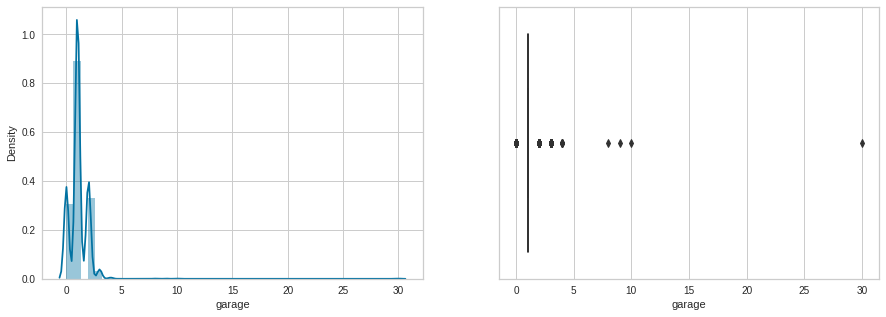

In [136]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.distplot(df['garage'], ax = axes[0])
sns.boxplot(df['garage'], ax = axes[1])
plt.show()

In [137]:
df[df.garage >= 5]

,crawled_at,address,estado,city,area,rooms,bathrooms,garage,condo,price_rent
1096,2022-06-23 21:48:00,"Rua Rio Grande do Norte, 1299 - Funcionários, ...",MG,belo-horizonte,65.0,1.0,1.0,30.0,290.0,1600.0
2222,2022-06-23 22:06:00,"Rua João Antônio de Oliveira, 55 - Móoca, São ...",SP,sao-paulo,100.0,3.0,3.0,10.0,950.0,4800.0
2336,2022-06-23 22:07:00,"Avenida Aratãs, 650 - Moema, São Paulo - SP",SP,sao-paulo,93.0,2.0,3.0,9.0,1345.0,4000.0
2542,2022-06-23 22:14:00,"CA 10, 302 - Lago Norte, Brasília - DF",DF,brasilia,88.0,2.0,1.0,8.0,850.0,4300.0


Existem imóveis com valores bastantes altos de vagas na garagem, valores esses que talvez sejam resultado de erros de digitação. Por serem poucos imóveis, irei removê-los.

In [138]:
# Removendo imóveis com valores exagerados de vagas na garagem (garage)
df = df.drop(df[df.garage >= 8].index)

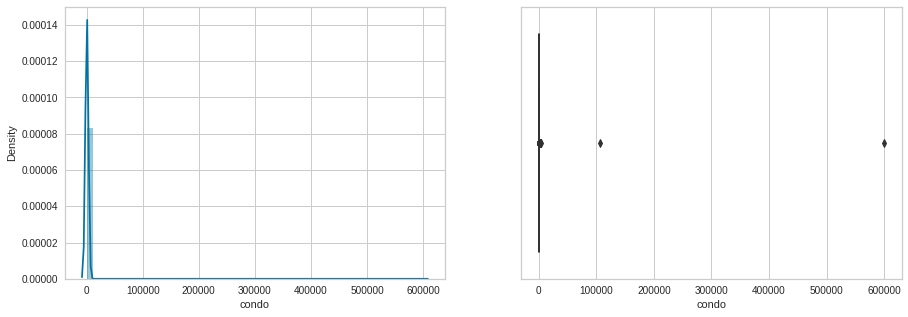

In [139]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.distplot(df['condo'], ax = axes[0])
sns.boxplot(df['condo'], ax = axes[1])
plt.show()

In [140]:
df[df.condo >= 10000]

,crawled_at,address,estado,city,area,rooms,bathrooms,garage,condo,price_rent
726,2022-06-23 21:35:00,"Rua dos Navegantes - Boa Viagem, Recife - PE",PE,recife,95.0,3.0,3.0,2.0,107000.0,2300.0
1529,2022-06-23 21:55:00,"Rua Almirante Alexandrino, 16 - Santa Teresa, ...",RJ,rio-de-janeiro,75.0,2.0,1.0,0.0,600000.0,2200.0


Assim como as features anteriores, existem imóveis com valores de condominio altissimos que talvez sejam resultado de erros de digitação. Por serem poucos imóveis, irei removê-los.

In [141]:
# Removendo imóveis com outliers de condominio (condo)
df = df.drop(df[df.condo >= 10000].index)

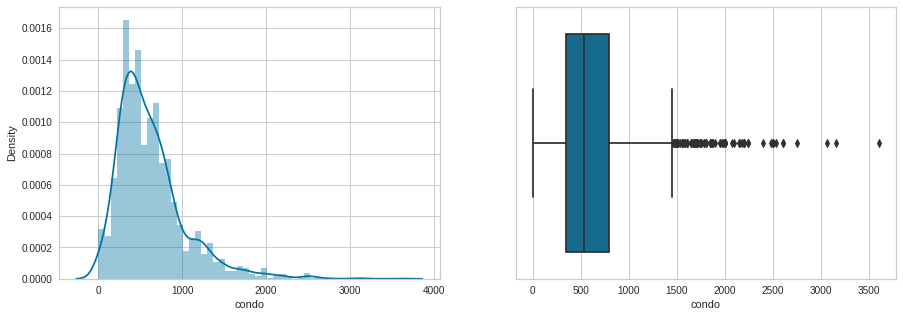

In [142]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.distplot(df['condo'], ax = axes[0])
sns.boxplot(df['condo'], ax = axes[1])
plt.show()

In [143]:
df[["area", "rooms", "bathrooms", "garage", 'condo', "price_rent"]].describe().T

,count,mean,std,min,25%,50%,75%,max
area,2294.0,78.947254,104.572985,10.0,51.0,69.0,90.00,4700.0
rooms,2294.0,2.145597,0.847605,1.0,1.0,2.0,3.00,5.0
bathrooms,2294.0,1.758936,0.896690,1.0,1.0,2.0,2.00,8.0
garage,2294.0,1.063208,0.711820,0.0,1.0,1.0,1.00,4.0
condo,2294.0,623.568003,413.248985,1.0,350.0,530.0,793.75,3600.0
price_rent,2294.0,2077.329555,1032.651448,395.0,1280.0,1862.5,2700.00,4990.0


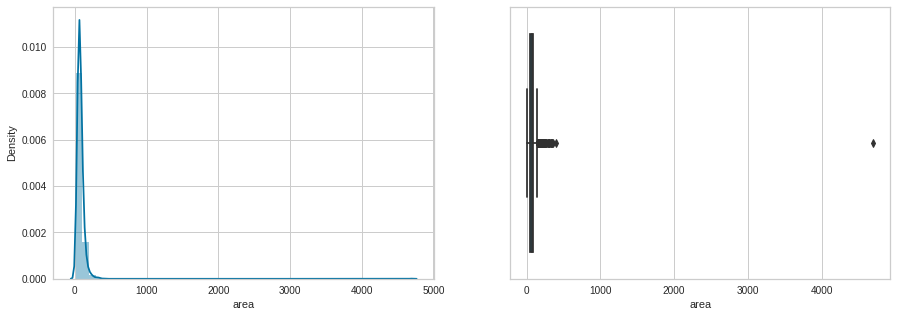

In [144]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.distplot(df['area'], ax = axes[0])
sns.boxplot(df['area'], ax = axes[1])
plt.show()

In [145]:
df = df.drop(df[df.area >= 1000].index)

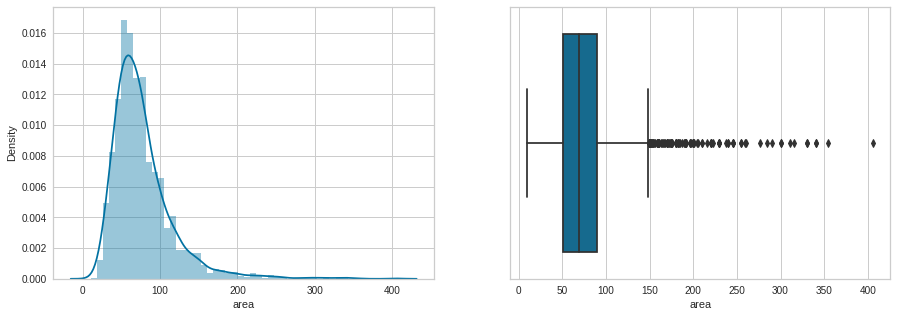

In [146]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.distplot(df['area'], ax = axes[0])
sns.boxplot(df['area'], ax = axes[1])
plt.show()

##**Separando as features em grupos**

In [147]:
# Separando as colunas em grupos
target = "price_rent"
numerical_features = ["area", "rooms", "bathrooms", "garage", 'condo']
categorical_features = ["estado"]

## **Criando funções auxiliares**

In [85]:
### Criando Funções
## Aplicação dos modelos
# Modelo de Regressão Linear
def model_linear_apply(model, x_train, x_test, y_train):
  lm = model()
  lm.fit(x_train, y_train)
  yHat = lm.predict(x_test)
  return yHat

# Avaliação do modelo
def evaluate_model(y_test, yHat):
  ax1=sns.distplot(y_test, hist=False, color='r', label='Valor Real')
  sns.distplot(yHat, hist=False, ax=ax1, color='b', label='Valor Previsto')
  plt.legend()
  plt.show()
  stats = pd.DataFrame({  
      'R2'    : r2_score(y_test, yHat),
      'MAE'    : mean_absolute_error(y_test, yHat),  
      'MSE'   : mean_squared_error(y_test, yHat), 
      'RMSE'  : np.sqrt(mean_squared_error(y_test, yHat))
      }, index = ['RESULT'])
  return stats


## Criando Pipeline de trabalho
# Regressão Linear 
def pipeline_linear(X, Y, model, test_size_p):
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size_p, random_state=42)
  yHat = model_linear_apply(model, x_train, x_test, y_train)
  stats = evaluate_model(y_test, yHat)
  return stats

##**Baseline**

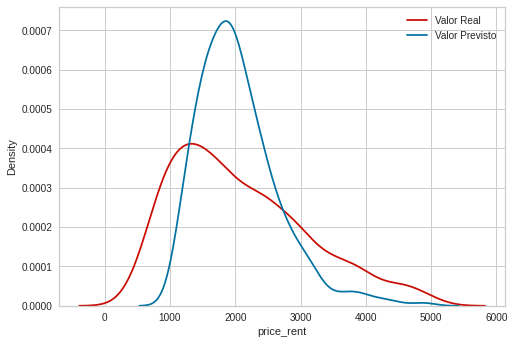

,R2,MAE,MSE,RMSE
RESULT,0.375637,630.916069,664306.841917,815.050208


In [86]:
x_target = df[numerical_features]
y_target = df[target]

# Modelo Linear
pipeline_linear(  
    X = x_target,   
    Y = y_target,   
    model = LinearRegression, 
    test_size_p = 0.3 
    )

#**Holdout treino e teste**


Treinando Modelo LinearRegression


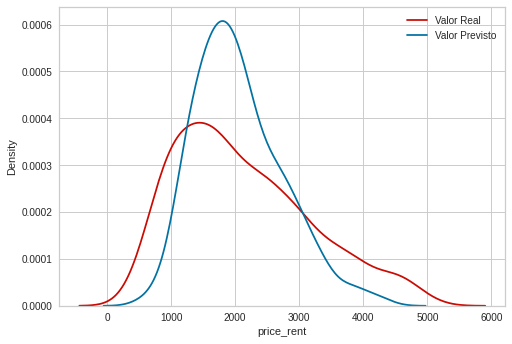

,R2,MAE,MSE,RMSE
LinearRegression,0.46721,583.641727,582371.573198,763.132736


In [157]:
scaler = MinMaxScaler()
ohe = OneHotEncoder()
data_pipeline = ColumnTransformer([("numerical", scaler, numerical_features),
                                   ("categorical", ohe, categorical_features)],
                                  remainder="passthrough")
x = df[numerical_features + categorical_features]
y = df[target]
x_train, x_test, y_train,y_test = train_test_split(x, y, test_size= .2, random_state=42)


x_train_transformed = data_pipeline.fit_transform(x_train)
x_test_transformed = data_pipeline.transform(x_test)

model = LinearRegression()

print(f'Treinando Modelo {model.__class__.__name__}')
model.fit(x_train_transformed, y_train)
yHat = model.predict(x_test_transformed)

result = pd.DataFrame({}) 
stats = pd.DataFrame({  
      'R2'    : r2_score(y_test, yHat),
      'MAE'    : mean_absolute_error(y_test, yHat),  
      'MSE'   : mean_squared_error(y_test, yHat), 
      'RMSE'  : np.sqrt(mean_squared_error(y_test, yHat))
      }, index = [f'{model.__class__.__name__}'])

result = result.append([stats])
ax1=sns.distplot(y_test, hist=False, color='r', label='Valor Real')
sns.distplot(yHat, hist=False, ax=ax1, color='b', label='Valor Previsto')
plt.legend()
plt.show()

result

# **Fitting model**

In [158]:
# Lista de modelos a serem treinados
reg_list = [RidgeCV(),
            Lasso(),
            ElasticNet(), 
            HuberRegressor(),
            LGBMRegressor(), 
            XGBRegressor(objective='reg:squarederror'),
            SVR(),
            KNeighborsRegressor(),
            RandomForestRegressor(),
            AdaBoostRegressor(),
            GradientBoostingRegressor(),
            MLPRegressor()
            ]

Treinando Modelo RidgeCV


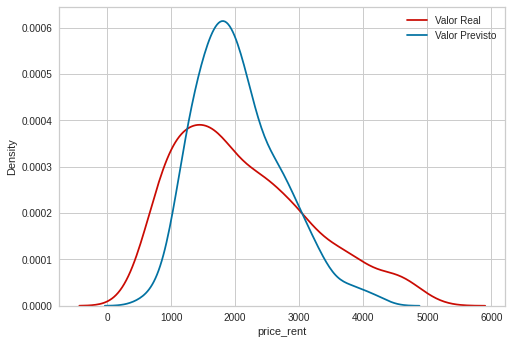

Treinando Modelo Lasso


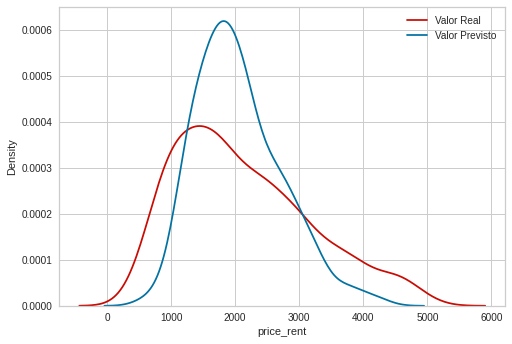

Treinando Modelo ElasticNet


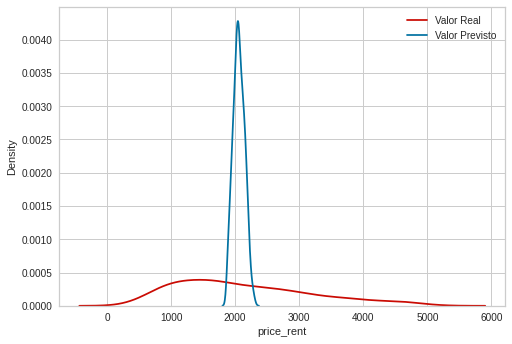

Treinando Modelo HuberRegressor


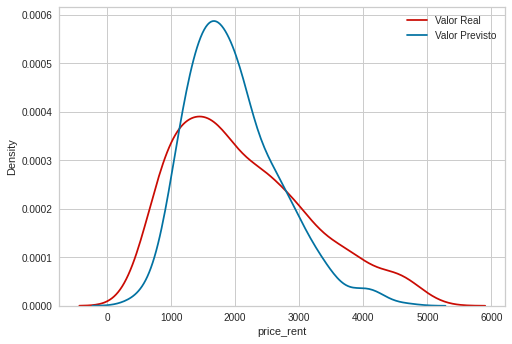

Treinando Modelo LGBMRegressor


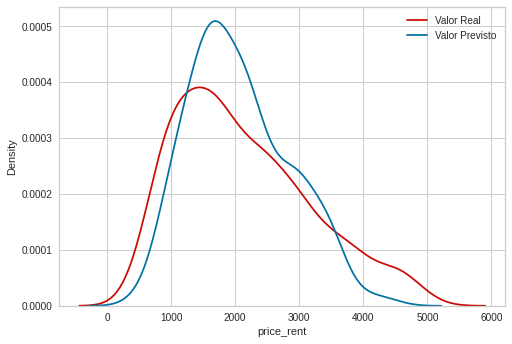

Treinando Modelo XGBRegressor


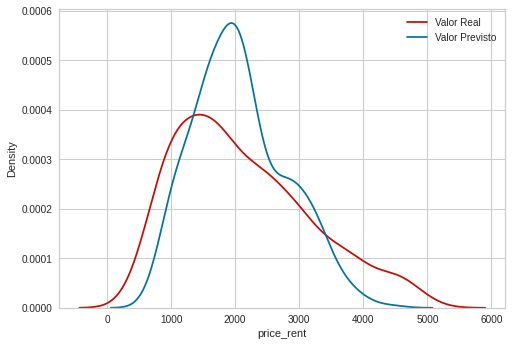

Treinando Modelo SVR


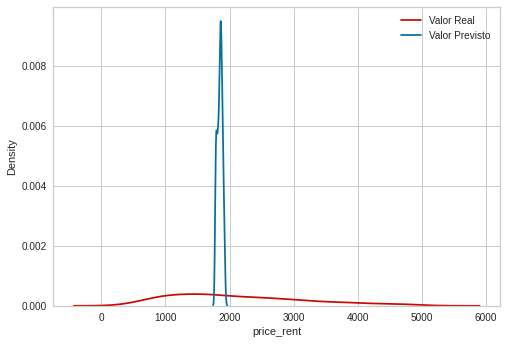

Treinando Modelo KNeighborsRegressor


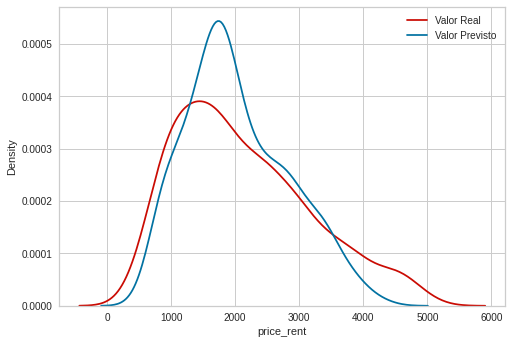

Treinando Modelo RandomForestRegressor


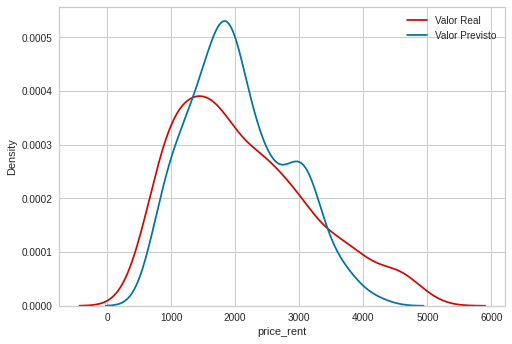

Treinando Modelo AdaBoostRegressor


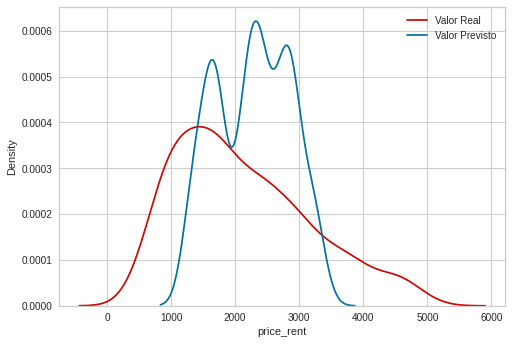

Treinando Modelo GradientBoostingRegressor


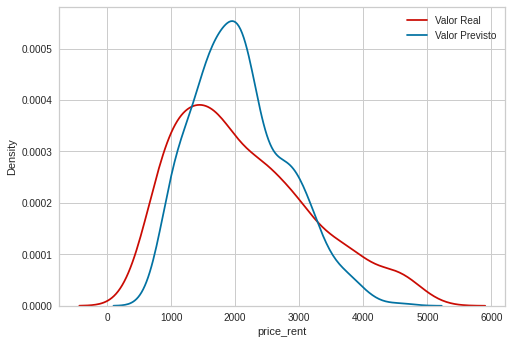

Treinando Modelo MLPRegressor


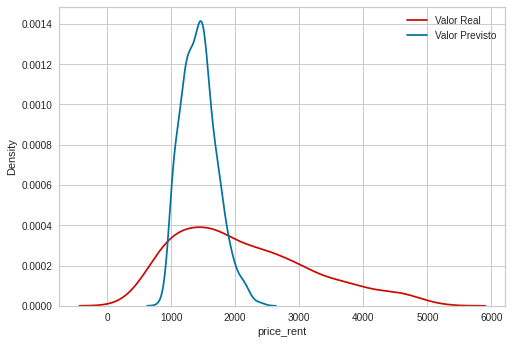

,R2,MAE,MSE,RMSE
XGBRegressor: MinMaxScaler,0.511139,559.252209,5.343546e+05,730.995602
GradientBoostingRegressor: MinMaxScaler,0.508112,557.963683,5.376632e+05,733.255216
LGBMRegressor: MinMaxScaler,0.491564,564.827337,5.557512e+05,745.487227
RidgeCV: MinMaxScaler,0.466470,585.370060,5.831804e+05,763.662463
Lasso: MinMaxScaler,0.460692,588.309525,5.894956e+05,767.786188
KNeighborsRegressor: MinMaxScaler,0.456459,576.820044,5.941224e+05,770.793371
RandomForestRegressor: MinMaxScaler,0.452362,588.343179,5.986007e+05,773.692910
HuberRegressor: MinMaxScaler,0.447099,576.829301,6.043543e+05,777.402260
AdaBoostRegressor: MinMaxScaler,0.366429,679.836138,6.925309e+05,832.184405
ElasticNet: MinMaxScaler,0.091438,812.415045,9.931129e+05,996.550503


In [167]:
scaler = MinMaxScaler()
ohe = OneHotEncoder()
data_pipeline = ColumnTransformer([("numerical", scaler, numerical_features),
                                   ("categorical", ohe, categorical_features)],
                                  remainder="passthrough")
x = df[numerical_features + categorical_features]
y = df[target]
x_train, x_test, y_train,y_test = train_test_split(x, y, test_size= .2, random_state=42)


x_train_transformed = data_pipeline.fit_transform(x_train)
x_test_transformed = data_pipeline.transform(x_test)

# Dataframe para armazenamento dos resultados
result_normalized = pd.DataFrame({})

# Aplicação dos modelos
for model in reg_list:
    print(f'Treinando Modelo {model.__class__.__name__}')
    model.fit(x_train_transformed, y_train)
    yHat = model.predict(x_test_transformed)
    
    stats = pd.DataFrame({  
      'R2'    : r2_score(y_test, yHat),
      'MAE'    : mean_absolute_error(y_test, yHat),  
      'MSE'   : mean_squared_error(y_test, yHat), 
      'RMSE'  : np.sqrt(mean_squared_error(y_test, yHat))
      }, index = [f'{model.__class__.__name__}: MinMaxScaler'])

    result_normalized = result_normalized.append([stats])
    ax1=sns.distplot(y_test, hist=False, color='r', label='Valor Real')
    sns.distplot(yHat, hist=False, ax=ax1, color='b', label='Valor Previsto')
    plt.legend()
    plt.show()
    print('='*80)

result_normalized.sort_values(by=['R2'], ascending = False)

Treinando Modelo RidgeCV


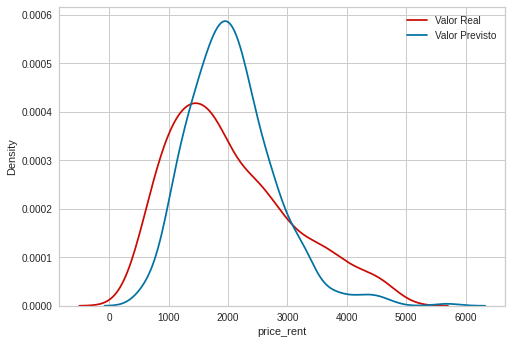

Treinando Modelo Lasso


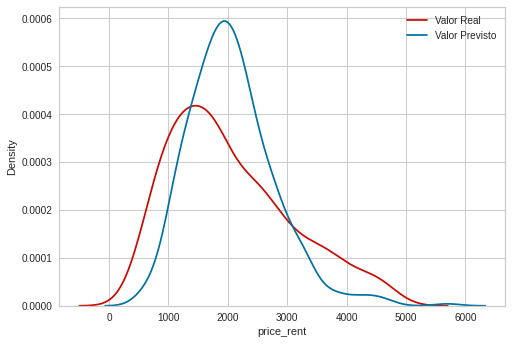

Treinando Modelo ElasticNet


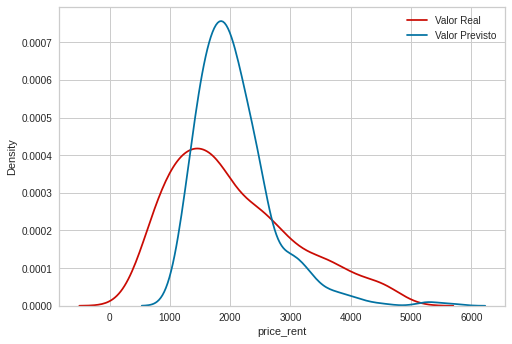

Treinando Modelo HuberRegressor


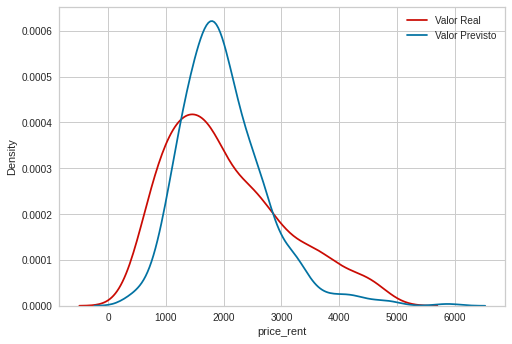

Treinando Modelo LGBMRegressor


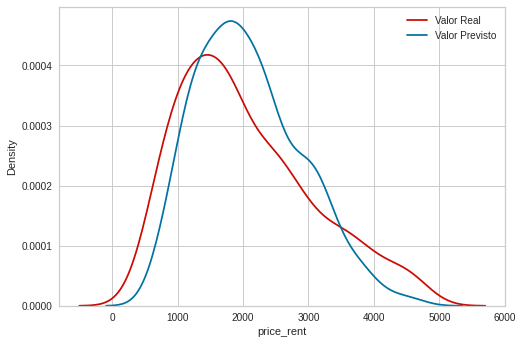

Treinando Modelo XGBRegressor


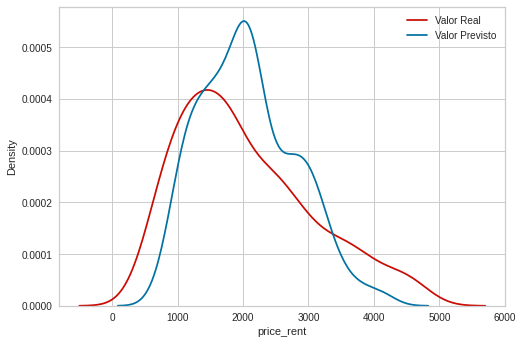

Treinando Modelo SVR


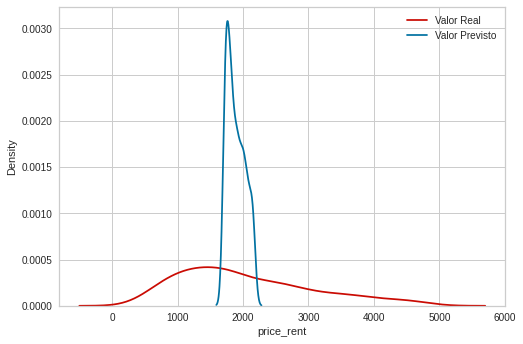

Treinando Modelo KNeighborsRegressor


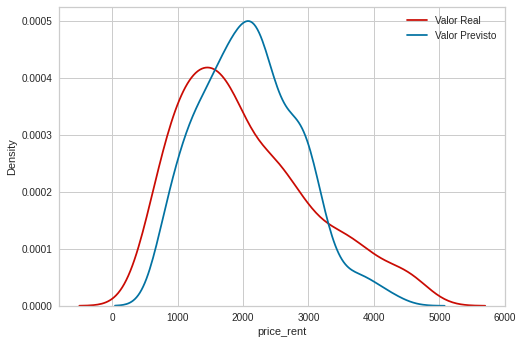

Treinando Modelo RandomForestRegressor


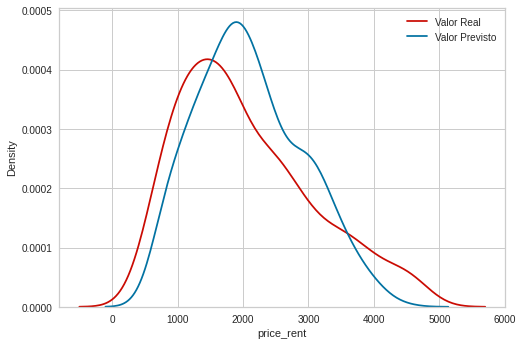

Treinando Modelo AdaBoostRegressor


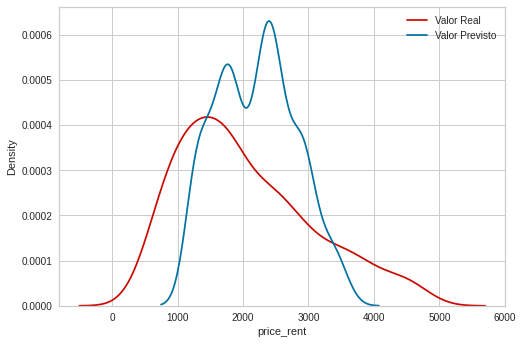

Treinando Modelo GradientBoostingRegressor


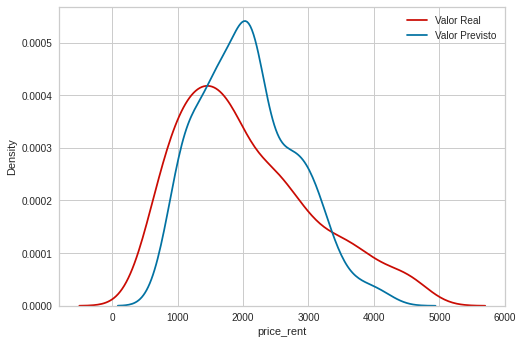

Treinando Modelo MLPRegressor


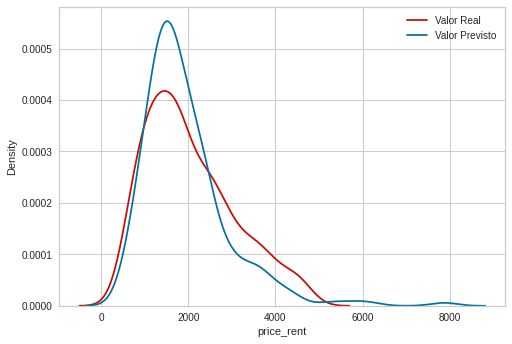

,R2,MAE,MSE,RMSE
GradientBoostingRegressor: OneHotEncoder_only,0.498444,566.850369,523817.655741,723.752482
XGBRegressor: OneHotEncoder_only,0.491298,575.808233,531280.881377,728.890171
LGBMRegressor: OneHotEncoder_only,0.478760,560.583353,544375.290260,737.817925
RandomForestRegressor: OneHotEncoder_only,0.456479,576.041067,567645.216073,753.422336
RidgeCV: OneHotEncoder_only,0.446455,591.711524,578114.748834,760.338575
Lasso: OneHotEncoder_only,0.443159,593.549396,581556.104409,762.598259
HuberRegressor: OneHotEncoder_only,0.404541,600.367855,621889.142442,788.599482
AdaBoostRegressor: OneHotEncoder_only,0.369509,667.887519,658476.014121,811.465350
ElasticNet: OneHotEncoder_only,0.343031,647.833192,686128.803005,828.328922
KNeighborsRegressor: OneHotEncoder_only,0.241395,689.978214,792275.965664,890.098852


In [168]:
ohe = OneHotEncoder()
data_pipeline = ColumnTransformer([("categorical", ohe, ["estado"])],
                                  remainder="passthrough")

x = df[numerical_features + categorical_features]
y = df[target]

x_train, x_test, y_train,y_test = train_test_split(x, y, test_size= .2, random_state=12345)


x_train_transformed = data_pipeline.fit_transform(x_train)
x_test_transformed = data_pipeline.transform(x_test)

# Dataframe para armazenamento dos resultados
result_one = pd.DataFrame({})

# Aplicação dos modelos
for model in reg_list:
    print(f'Treinando Modelo {model.__class__.__name__}')
    model.fit(x_train_transformed, y_train)
    yHat = model.predict(x_test_transformed)
    
    stats = pd.DataFrame({  
      'R2'    : r2_score(y_test, yHat),
      'MAE'    : mean_absolute_error(y_test, yHat),  
      'MSE'   : mean_squared_error(y_test, yHat), 
      'RMSE'  : np.sqrt(mean_squared_error(y_test, yHat))
      }, index = [f'{model.__class__.__name__}: OneHotEncoder_only'])

    result_one  = result_one .append([stats])
    ax1=sns.distplot(y_test, hist=False, color='r', label='Valor Real')
    sns.distplot(yHat, hist=False, ax=ax1, color='b', label='Valor Previsto')
    plt.legend()
    plt.show()
    print('='*80)

result_one .sort_values(by=['R2'], ascending = False)

In [169]:
# Concatenando os resultados de diferentes modelos com diferentes tratamentos
result = pd.concat([result_normalized, result_one])

# Ordenando os melhores modelos com base em seu score
result.sort_values(by=['R2'], ascending = False)

,R2,MAE,MSE,RMSE
XGBRegressor: MinMaxScaler,0.511139,559.252209,5.343546e+05,730.995602
GradientBoostingRegressor: MinMaxScaler,0.508112,557.963683,5.376632e+05,733.255216
GradientBoostingRegressor: OneHotEncoder_only,0.498444,566.850369,5.238177e+05,723.752482
LGBMRegressor: MinMaxScaler,0.491564,564.827337,5.557512e+05,745.487227
XGBRegressor: OneHotEncoder_only,0.491298,575.808233,5.312809e+05,728.890171
LGBMRegressor: OneHotEncoder_only,0.478760,560.583353,5.443753e+05,737.817925
RidgeCV: MinMaxScaler,0.466470,585.370060,5.831804e+05,763.662463
Lasso: MinMaxScaler,0.460692,588.309525,5.894956e+05,767.786188
RandomForestRegressor: OneHotEncoder_only,0.456479,576.041067,5.676452e+05,753.422336
KNeighborsRegressor: MinMaxScaler,0.456459,576.820044,5.941224e+05,770.793371


o XGBoostRegressor com os dados normalizados através do MinMaxScaler e com a aplicação do OneHotEnconder foi o modelo com melhor desempenho entre todos os testados.

##**Ajustando Hiperparâmetros**

In [170]:
scaler = MinMaxScaler()
ohe = OneHotEncoder()
data_pipeline = ColumnTransformer([("numerical", scaler, numerical_features),
                                   ("categorical", ohe, categorical_features)],
                                  remainder="passthrough")
x = df[numerical_features + categorical_features]
y = df[target]
x_train, x_test, y_train,y_test = train_test_split(x, y, test_size= .2, random_state=42)


x_train_transformed = data_pipeline.fit_transform(x_train)
x_test_transformed = data_pipeline.transform(x_test)


# Números de árvores a serem usadas
xgb_n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]

# Número máximo de niveis na árvore
xgb_max_depth = [int(x) for x in np.linspace(2, 20, 10)]

# Número mínimo de instâncias em cada nó
xgb_min_child_weight = [int(x) for x in np.linspace(1, 10, 10)]

# Construção da árvore usada no XGBoost
xgb_tree_method = ['auto', 'exact', 'approx', 'hist', 'gpu_hist']

# Taxa de aprendizagem
xgb_eta = [x for x in np.linspace(0.1, 0.6, 6)]

# Redução de perda mínima necessária para fazer mais partição
xgb_gamma = [int(x) for x in np.linspace(0, 0.5, 6)]

# Objetivo de aprendizagem usado
xgb_objective = ['reg:squarederror', 'reg:squaredlogerror']

# Criando os parâmetros
params = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'tree_method': xgb_tree_method,
            'eta': xgb_eta,
            'gamma': xgb_gamma,
            'objective': xgb_objective}

reg = XGBRegressor()

# Rodando a busca por parâmetros
n_iter_search = 100
random_search = RandomizedSearchCV(reg, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, n_jobs=-1)

start = time.time()
random_search.fit(x_train_transformed, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
print("Best parameters:", random_search.best_params_)
print("Best Score (R2): ", (random_search.best_score_))

RandomizedSearchCV took 526.62 seconds for 100 candidates parameter settings.
Best parameters: {'tree_method': 'approx', 'objective': 'reg:squarederror', 'n_estimators': 800, 'min_child_weight': 6, 'max_depth': 2, 'gamma': 0, 'eta': 0.2}
Best Score (R2):  0.5207633521691873


##**Salvando o Modelo**

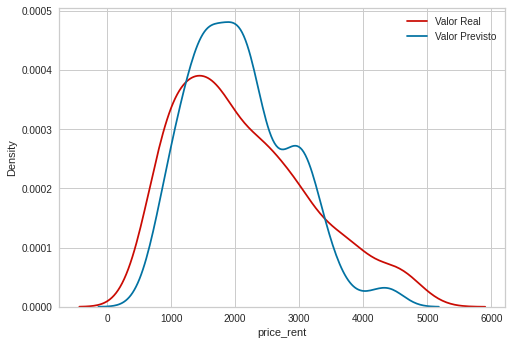

,R2,MAE,MSE,RMSE
XGBRegressor: log,0.522599,539.479687,521827.421357,722.376233


In [172]:
scaler = MinMaxScaler()
ohe = OneHotEncoder()
data_pipeline = ColumnTransformer([("numerical", scaler, numerical_features),
                                   ("categorical", ohe, categorical_features)],
                                  remainder="passthrough")
x = df[numerical_features + categorical_features]
y = df[target]
x_train, x_test, y_train,y_test = train_test_split(x, y, test_size= .2, random_state=42)


x_train_transformed = data_pipeline.fit_transform(x_train)
x_test_transformed = data_pipeline.transform(x_test)


# Aplicação dos modelos
model = XGBRegressor(tree_method = 'approx', objective = 'reg:squarederror', n_estimators = 800, min_child_weight = 6, max_depth = 2, gamma = 0, eta = 0.2)



model.fit(x_train_transformed, y_train)
yHat = model.predict(x_test_transformed)

result_log = pd.DataFrame({})
stats = pd.DataFrame({  
      'R2'    : r2_score(y_test, yHat),
      'MAE'    : mean_absolute_error(y_test, yHat),  
      'MSE'   : mean_squared_error(y_test, yHat), 
      'RMSE'  : np.sqrt(mean_squared_error(y_test, yHat)),
      }, index = [f'{model.__class__.__name__}: log'])

result_log = result_log.append([stats])
ax1=sns.distplot(y_test, hist=False, color='r', label='Valor Real')
sns.distplot(yHat, hist=False, ax=ax1, color='b', label='Valor Previsto')
plt.legend()
plt.show()
result_log

In [173]:
# save in JSON format
model.save_model("drive/MyDrive/regressor.json")
# save in text format
model.save_model("drive/MyDrive/regressor.txt")